# ABOUT THIS NOTEBOOK
## Purpose
This notebook reads in the data set for the project, processes the data and outputs pickle file for use by other notebooks.
## Input
Datasets from the Didi Algorithm Competition. This data is organized in the following folders:    
* data/season_1/training_data/  
* data/season_1/test_set_1  

## Output
The following pickle file is generated:    
* data_set.pickle       

## Tasks Performed
* Load library packages
* Load datasets
* Process data
    * Generate a new feature that measure the mean traffic intenstity
    * Handle missing data for traffic (district 54, time_slot=1)
    * Reduce POI data using PCA
    * Generate a POI cluster ID for each district
* Generate unified dataframe
    * Handle missing data for weather & traffic
    * Handle categorical data (district_id, num_day, time_slot, week_day, poi_cluster)
* Generate pickle file
* Review input features     
  This is done periodically while processing the data set. Identify missing & categorical data.

# LOAD LIBRARY PACKAGES

In [1]:
# Import the required library packages
import os
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from six.moves import cPickle as pickle

print 'Read in packages from os, numpy, pandas, matplotlib, seaborn, sklearn, scipy & six'

# Settings for matplotlib, Seaborn
%matplotlib inline
sns.set_style('whitegrid')
print 'Matplotlib is inline. Seaborn defaults to whitegrid'

Read in packages from os, numpy, pandas, matplotlib, seaborn, sklearn, scipy & six
Matplotlib is inline. Seaborn defaults to whitegrid


# LOAD DATASETS
## Read Order, Weather, Cluster Map, POI & Traffic Data

In [2]:
# Variables for data directory & dates
data_dir = '../../../../../data/season_1/'
dates_ = range(1, 22)
dates = ["{:02d}".format(item) for item in dates_] 

# Read in order data - multiple input files
order_data = pd.concat(pd.read_table(data_dir + 'training_data/order_data/order_data_2016-01-%s' %i, 
                                     header=None, 
                                     names = ['order_id', 'driver_id', 'passenger_id', 'start_district_hash', 
                                                'dest_district_hash', 'Price', 'Time'])
                       for i in dates)

# Read in weather data - multiple input files                                                                                                                                                           
weather_data = pd.concat(pd.read_table(data_dir + 'training_data/weather_data/weather_data_2016-01-%s' %i, 
                                       header=None, 
                                       names = ['Time', 'Weather', 'temperature', 'PM2.5'])
                         for i in dates)                      

# Read in cluster map data
district_data = pd.read_table(data_dir + 'test_set_1/cluster_map/cluster_map',
                              sep=' ', header=None, 
                              names=['district_hash'])

# Read in POI data
poi_data = pd.read_table(data_dir + 'training_data/poi_data/poi_data', 
                         sep=' ', header=None, 
                         names = ['district_hash'])

# Read in traffic data - multiple input files
traffic_data = pd.concat(pd.read_table(data_dir + 'training_data/traffic_data/traffic_data_2016-01-%s' %i, 
                                       sep=' ', header=None, 
                                       names = ['district_hash_orig', 'time'])
                         for i in dates)

# PROCESS DATA

## Functions

In [3]:
def dist_hash2id(data_frame, hash_col, district_dict):
    '''Map district_hash to district_id based on cluster map table.
    
    Arguments:
    data_frame -- dataframe containing the district hash
    hash_col -- column name containing the district hash
    district_dict -- dictionary that maps district_hash to district_id
    
    Returns:
    Array containing the mapped district_id for the district_hash column in the dataframe
    '''
    
    idvalue_array = []
    
    for hash_value in data_frame[hash_col]:
        idvalue_array.append(district_dict[hash_value])
    
    return idvalue_array


def time_stamp2slot(arr_hour, arr_minute, arr_second):
    '''Map time_stamp to time_slot. 
    hh:mm:ss --> [1:144]
    
    Arguments:
    arr_hour -- array containing the hour value
    arr_minute -- array containing the minute value
    arr_second -- array containing the second value
    
    Returns:
    Array containing the time slot values
    '''
    
    time_slot = []
    
    for hour, minu, sec in zip(arr_hour, arr_minute, arr_second):
        time_slot.append(int((6*hour + 0.1*minu + sec/600) + 1))
    
    return time_slot


def time_axis(num_day, time_slot):
    '''Combine num_day and time_slot to create a new time_axis.
    Each day after the first day accumulates 144 time slots. 
    Returned value includes the sum of the times slots from num_day and the time_slot argument.
    
    Arguments:
    num_day -- ranging from 1 to 22
    time_slot -- ranging from 1 to 144
    
    Returns:
    time_axis value
    '''
    
    return (((num_day - 1)*144) + time_slot)


def demand_supply(order_frame):
    '''Calculate demand, supply and gap per time axis slot.
    Demand = Number of orders received (ride requests)
    Supply = Number of orders answered
    Gap = Number of orders missed (NA)
    
    Arguments:
    order_frame -- dataframe that contains order information
    
    Returns:
    Dictionaries containing demand, supply & gap data indexed by district id & time
    '''
        
    demand = {}
    supply = {}
    gap = {}
    
    # Initialize demand & supply to zero
    for district in range(1,67):
        for time in range(1,31*144):
            demand[(district, time)] = 0;
            supply[(district, time)] = 0;

    # Iterate over all orders to accumulate demand, supply count for each time slot
    for district_id, num_day, time_slot, answered in zip(order_frame['district_id'], order_frame['num_day'], 
                                                         order_frame['time_slot'], order_frame['driver_id']):
        demand[(int(district_id),time_axis(num_day, time_slot))] += 1;
        supply[(int(district_id),time_axis(num_day, time_slot))] += pd.notnull(answered);
        
    # Calculate the demand-supply gap
    for district in range(1,67):
        for time in range(1,31*144):
            gap[(district, time)] = demand[(district, time)] - supply[(district, time)];
    
    # Use time_slot=1 values to prefill three earlier slots
    # These three earlier time slots are needed to ensure that all input features are defined for time_slot=1
    for district in range(1,67):
        for time in [-2, -1, 0]:
            demand[(district, time)] = demand[(district, 1)]
            supply[(district, time)] = supply[(district, 1)]
            gap[(district, time)] = gap[(district, 1)]
    
    return (demand, supply, gap)


def poi_all(poi_list):
    '''Parse & extract the poi labels.
    
    Arguments:
    POI information - tab separated, colon delineated
    
    Returns:
    Array with sorted POI labels
    '''
    z=[]
    for t in poi_list.split('\t'):
        z.append(t.split(':'))
        
    # sort in-place from highest to lowest
    z.sort(key=lambda x: int(x[1]), reverse=True)
    return z

## District Data Processing

In [4]:
# Generate dictionary to map district_hash to district_id (1...66)
district_data = pd.DataFrame(district_data.district_hash.str.split('\W+',1).tolist(), 
                        columns = ['district_hash', 'district_id'])
district_dict = district_data.set_index('district_hash')['district_id'].to_dict()

## Order Data Processing

In [5]:
# Convert Time column to datetime objects
order_data['Time'] = pd.to_datetime(order_data['Time']) 
order_data.set_index('Time', inplace=True)

# Create following features - num_day(1...31), time_slot (1...144), week_day (0...6) 
order_data['num_day'] = order_data.index.day
order_data['time_slot'] = time_stamp2slot(order_data.index.hour, 
                                          order_data.index.minute, 
                                          order_data.index.second)
order_data.reset_index(inplace='True')
order_data['week_day'] = order_data['Time'].dt.dayofweek

# Map start_district_hash to district_id (1...66)
order_data['district_id'] = dist_hash2id(order_data, 'start_district_hash', district_dict)

# Calculate demand, supply & gap for all district_id & time_slot
d_data = {}
s_data = {}
g_data = {}
d_data, s_data, g_data = demand_supply(order_data)

## Weather Data Processing

In [6]:
# Convert Time column to datetime objects
weather_data['Time'] = pd.to_datetime(weather_data['Time']) 
weather_data.set_index('Time', inplace=True)

# Create following features - num_day(1...31), time_slot (1...144), week_day (0...6) 
weather_data['num_day'] = weather_data.index.day
weather_data['time_slot'] = time_stamp2slot(weather_data.index.hour, 
                                            weather_data.index.minute, 
                                            weather_data.index.second)
weather_data.reset_index(inplace='True')
weather_data['week_day'] = weather_data['Time'].dt.dayofweek

## Traffic Data Processing

In [7]:
# Extract tj_level, date & Time information
split1 = []
split1 = traffic_data.district_hash_orig.str.split('[\W+]',1).tolist()

district_hash = []
tj_date =[]
for x in split1:
    district_hash.append(x[0])
    tj_date.append(x[1])
    
traffic_data['district_hash'] = district_hash
traffic_data['tj_date'] = tj_date

split2 =[]
split2 = traffic_data.tj_date.str.split('(\d{4}\-\d{2}\-\d{2}$)',1).tolist()

tj_level =[]
date = []
for x in split2:
    tj_level.append(x[0])
    date.append(x[1])
    
traffic_data['tj_level'] = tj_level
traffic_data['date'] = date
traffic_data['Time'] = traffic_data.apply(lambda r: str(r.date) + ' ' + str(r.time), axis=1)

# Convert to datetime object
traffic_data['Time'] = pd.to_datetime(traffic_data['Time'])

# Create following features -  num_day(1...31), time_slot (1...144), week_day (0...6) 
traffic_data.set_index('Time', inplace=True)
traffic_data['num_day'] = traffic_data.index.day
traffic_data['time_slot'] = time_stamp2slot(traffic_data.index.hour, 
                                            traffic_data.index.minute, 
                                            traffic_data.index.second)
traffic_data.reset_index(inplace='True')
traffic_data['week_day'] = traffic_data['Time'].dt.dayofweek

# Map district_hash to district_id (1...66)
traffic_data['district_id'] = dist_hash2id(traffic_data, 'district_hash', district_dict)

In [8]:
# Split tj_level in to 4 columns - one column for each traffic level 
intensity_array = []
tj_lvl1 = []
tj_lvl2 = []
tj_lvl3 = []
tj_lvl4 = []
    
for tj_level in traffic_data['tj_level']:
    traffic = {}
    for level in tj_level.split('\t')[:4]:
        [lvl, num_roads] = level.split(':')
        traffic[lvl] = int(num_roads)
            
    tj_lvl1.append(traffic['1'])
    tj_lvl2.append(traffic['2'])
    tj_lvl3.append(traffic['3'])
    tj_lvl4.append(traffic['4'])

# Add new columns, Drop unused columns
traffic_data['tj_lvl1'] = tj_lvl1
traffic_data['tj_lvl2'] = tj_lvl2
traffic_data['tj_lvl3'] = tj_lvl3
traffic_data['tj_lvl4'] = tj_lvl4
traffic_data.drop(['district_hash_orig', 'time', 'tj_date'], axis=1, inplace=True)

## Traffic Data Processing - Handle Missing Data

### Traffic data is missing for district 54
We will use the data from district 39 as a substitute for the missing traffic data for district 54.    
After performing POI clustering (in the next section), we find that district 54 is located in a cluster whose centroid is district 39.    

In [9]:
for num_day in range (1,22):
    for time_slot in range (1,145):
        traffic = traffic_data[(traffic_data.num_day == num_day) & 
                           (traffic_data.time_slot == time_slot) & 
                           (traffic_data.district_id == str(39))]
        
        if (traffic['tj_lvl1'].empty):
            next

        else:
            tj_lvl1 = float(traffic['tj_lvl1'])
            tj_lvl2 = float(traffic['tj_lvl2'])
            tj_lvl3 = float(traffic['tj_lvl3'])
            tj_lvl4 = float(traffic['tj_lvl4'])
        
            data = {'Time':          np.NaN, 
                    'district_hash': np.NaN, 
                    'tj_level':      np.NaN,
                    'date':          np.NaN,
                    'num_day':       num_day,
                    'time_slot':     time_slot,
                    'week_day':      np.NaN,
                    'district_id':   str(54),
                    'tj_lvl1':       tj_lvl1,
                    'tj_lvl2':       tj_lvl2,
                    'tj_lvl3':       tj_lvl3,
                    'tj_lvl4':       tj_lvl4
                   }
            
            df = pd.DataFrame(data, columns=list(traffic.columns.values), index=[0])
            traffic_data = traffic_data.append(df)

### Traffic Data is missing for num_day=1, time_slot=1
Use data from next time_slot (time_slot = 2)

In [10]:
# Copy traffic data for num_day = 1, time_slot = 1 from time_slot = 2 for all 66 districts
for district in range (1,67):
    traffic = traffic_data[(traffic_data.num_day == 1) & 
                           (traffic_data.time_slot == 2) & 
                           (traffic_data.district_id == str(district))]
        
    data = {'Time':          pd.to_datetime('2016-01-01 00:00:10'), 
            'district_hash': np.NaN, 
            'tj_level':      np.NaN,
            'date':          '2016-01-01',
            'num_day':       1,
            'time_slot':     1,
            'week_day':      4,
            'district_id':   str(district),
            'tj_lvl1':       float(traffic['tj_lvl1']),
            'tj_lvl2':       float(traffic['tj_lvl2']),
            'tj_lvl3':       float(traffic['tj_lvl3']),
            'tj_lvl4':       float(traffic['tj_lvl4'])
            }
        
    df = pd.DataFrame(data, columns=list(traffic.columns.values), index=[0])
    traffic_data = traffic_data.append(df)

## POI Data Processing

### Extract all POI types and their counts for each district
### Include these values as new columns

In [11]:
# Create district_hash, poi_class, district_id (1...66) columns
poi_data = pd.DataFrame(poi_data.district_hash.str.split('\W+',1).tolist(), 
                        columns = ['district_hash','poi_class'])
poi_data['district_id'] = dist_hash2id(poi_data, 'district_hash', district_dict)

# Find the unique set of poi labels
rr =[]
rr = poi_data.apply(lambda r: poi_all(r.poi_class), axis=1)

t =[]
for x in rr.values:
    for i in range(0,len(x)):
        t.append(x[i][0])
uniquepoi_set  = set(t)
uniquepoi_list = list(uniquepoi_set)

# Add one column for each unique poi label initialize to 0
poi_data = pd.concat([poi_data,pd.DataFrame(columns=uniquepoi_list)])
poi_data = poi_data.fillna(0)

# Fill in poi values for all districts
for i in range(0,66):
    for j in range(0,len(rr[i])):
        # (row, col, value)
        poi_data.set_value(i, rr[i][j][0], rr[i][j][1])

In [12]:
poi_data.shape

(66, 179)

## POI Data Processing - PCA

### Objective
There are ~176 POI types... we need to reduce the POI input feature dimension. We will use PCA to reduce dimensions and use the reduced dimensions as new features.

### Run PCA with 20 components and observe the variance by number of components

Transformed POI data set
PCA Components: 
[[ -9.59726996e-02  -8.36584765e-02  -5.51605004e-02 ...,  -9.59450457e-02
   -1.62210370e-02  -6.51074785e-03]
 [ -7.95904424e-03   1.08001117e-02  -7.34215501e-02 ...,   3.54100724e-02
    3.30097522e-02  -2.02857490e-02]
 [  2.77035808e-02   4.44727440e-02   1.61239903e-01 ...,  -1.50218779e-02
   -3.87498694e-02   2.60591456e-02]
 ..., 
 [ -7.95897969e-03   1.11332894e-02   1.43586260e-02 ...,  -1.35282409e-02
    1.76720905e-01   3.06616869e-02]
 [  3.20576546e-03  -8.35926943e-02  -2.97471924e-03 ...,   3.19624289e-02
    2.72465840e-02   4.01056138e-02]
 [  3.20758635e-05   3.82246256e-02   5.17089960e-03 ...,   2.24756440e-03
    3.52162781e-02   1.35822560e-02]]
PCA Explained Variance Ratio: 
[ 0.59316654  0.06522435  0.03398176  0.02982427  0.02261498  0.02060699
  0.01932321  0.01778027  0.01683588  0.01430757  0.01342396  0.01242426
  0.01157932  0.01057829  0.00852078  0.00838608  0.0076871   0.00691644
  0.00668168  0.00657814]


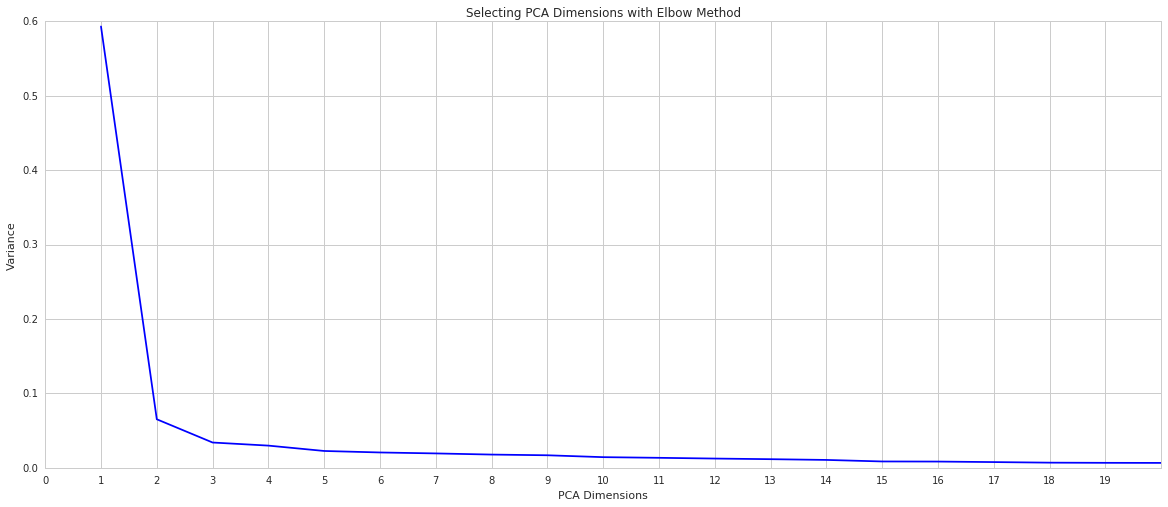

In [13]:
# Use a new dataframe called poi_data_pca
# Drop unused columns, set district_id as index
poi_data_pca = poi_data.drop(['district_hash', 'poi_class'], axis=1)
poi_data_pca.set_index('district_id', inplace=True)

# Normalize each column
scaler = StandardScaler().fit(poi_data_pca)
poi_data_pca_trans = scaler.transform(poi_data_pca)
print ("Transformed POI data set")

# Run PCA with 20 components
pca = PCA(n_components=20)
pca.fit(poi_data_pca_trans)

# Print the components and the amount of variance in the data contained in each dimension
print "PCA Components: \n{}" .format(pca.components_)
print "PCA Explained Variance Ratio: \n{}" .format(pca.explained_variance_ratio_)

# Plot Variance by number of components
x = np.array(range(1,21))
f, ax = plt.subplots(figsize=(20, 8))
plt.plot(x, pca.explained_variance_ratio_, 'bx-') 
plt.xlabel('PCA Dimensions') 
plt.ylabel('Variance') 
plt.title('Selecting PCA Dimensions with Elbow Method')
ax.set_xticks(np.arange(0,20))
plt.show()

Elbow seems to occur around n_components = 2 or 3.    
72.1% of variance can be captured in the first four components.     
We will select n_components = 4.

### Rerun PCA with n_components=4 and reduce data

In [14]:
# Reduce the data to four dimensions using PCA
pca4 = PCA(n_components=4)
reduced_data = pca4.fit_transform(poi_data_pca_trans)
reduced_datatr = np.transpose(reduced_data)

# Create new columns to store PC1, PC2, PC3, PC4
poi_data['poi_pc1'] = reduced_datatr[0]
poi_data['poi_pc2'] = reduced_datatr[1]
poi_data['poi_pc3'] = reduced_datatr[2]
poi_data['poi_pc4'] = reduced_datatr[3]

## Visualize Clusters, Calculate Centroids

### Rerun PCA with n_components=2
### Implement Clustering using KMeans

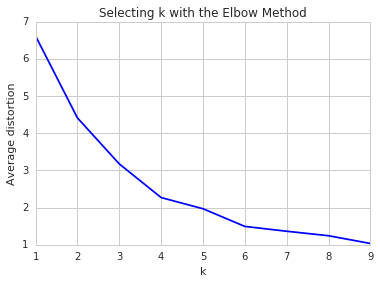

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=6, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)


In [15]:
# Reduce the data to two dimensions using PCA for visualization
pca2 = PCA(n_components=2)
reduced_data = pca2.fit_transform(poi_data_pca_trans)

# Implement clustering algorithm and fit it to the reduced data for visualization
# The visualizer below assumes clustering object is named 'clusters'
# Implement elbow method to determine n_clusters
K = range(1, 10) 
meandistortions = [] 
for k in K: 
     kmeans = KMeans(n_clusters=k) 
     kmeans.fit(reduced_data) 
     meandistortions.append(sum(np.min(cdist(reduced_data, kmeans.cluster_centers_, 'euclidean'),
                                       axis=1)) / reduced_data.shape[0]) 

plt.plot(K, meandistortions, 'bx-') 
plt.xlabel('k') 
plt.ylabel('Average distortion') 
plt.title('Selecting k with the Elbow Method') 
plt.show()

# Derived n_clusters=6 from Elbow Plot 
clusters = KMeans(n_clusters=6)
clusters.fit(reduced_data)
print clusters

In [16]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

# Create new column that stores cluster labels
poi_data['poi_cluster'] = clusters.labels_

# Find the centroids for KMeans or the cluster means for GMM 
centroids = clusters.cluster_centers_
centroids_inv = pca2.inverse_transform(centroids)
print "Centroids transformed back to original space:"
print np.around(centroids_inv, 0)

print "Scaled Centroids in original space:"
scaled_centroids_inv = np.apply_along_axis(lambda x: x/np.linalg.norm(x), 1, centroids_inv) 
print np.around(scaled_centroids_inv, 5)

Centroids transformed back to original space:
[[-0. -0. -0. ..., -0. -0. -0.]
 [ 2.  1.  1. ...,  2.  0.  0.]
 [ 6.  5.  2. ...,  6.  1.  0.]
 [ 1.  0.  1. ...,  0. -0.  0.]
 [-0. -0. -0. ..., -0. -0.  0.]
 [ 3.  2.  2. ...,  2.  0.  0.]]
Scaled Centroids in original space:
[[-0.09552 -0.07956 -0.06928 ..., -0.08643 -0.00897 -0.01061]
 [ 0.09602  0.08358  0.05565 ...,  0.09571  0.016    0.00665]
 [ 0.0909   0.08369  0.03496 ...,  0.10176  0.02399  0.00121]
 [ 0.08607  0.06579  0.08533 ...,  0.06346 -0.00335  0.01612]
 [-0.08623 -0.08172 -0.02411 ..., -0.10224 -0.02727  0.00145]
 [ 0.0919   0.07343  0.07875 ...,  0.07555  0.0026   0.01367]]


### Find districts that are centroids

In [17]:
# Find the representative districts for each of the six clusters
for c_index, c in enumerate(centroids):
    shortest_dist = float('inf')
    closest_idx = -1
    for d_index, d in enumerate(reduced_data):
        dist = np.linalg.norm(c-d)
        if (dist < shortest_dist):
            shortest_dist = dist
            closest_idx = d_index
            
    print 'District #{0:2d} is the closest to centroid in cluster {1:2d}' .format(int(poi_data.iloc[[closest_idx]]['district_id']), 
                                                                       c_index)

District #39 is the closest to centroid in cluster  0
District #12 is the closest to centroid in cluster  1
District #51 is the closest to centroid in cluster  2
District #46 is the closest to centroid in cluster  3
District #19 is the closest to centroid in cluster  4
District #23 is the closest to centroid in cluster  5


### Scatter Plot

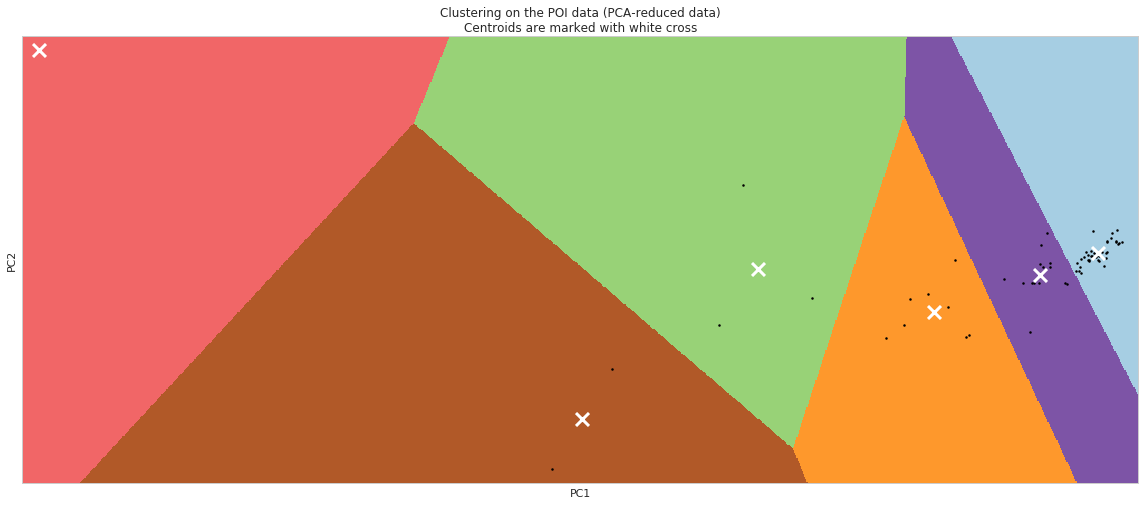

In [18]:
# Scatter Plot for Cluster Visualization
Z = Z.reshape(xx.shape)

plt.figure(figsize=(20,8))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=5)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the POI data (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlabel('PC1') 
plt.ylabel('PC2')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

NOTE: For visualization we use 2 components. However, we reduced the POI data to four components.

# GENERATE UNIFIED DATAFRAME

### Objective
Create a unified dataframe that arranges all the data (weather, traffic, demand, supply, gap, POI) by district & time.  
Our goal is to be able to access the data for each district on the time axis (21 days each split in to 144 time slots).     
Use previous available data for weather, traffic in place of missing data.

### Output
DATAFRAME:      
data_set 

COLUMNS:     
'district_id',      
'num_day', 'time_slot', 'week_day',      
'demand','demand_t-1', 'demand_t-2', 'demand_t-3',     
'supply', 'supply_t-1','supply_t-2', 'supply_t-3',     
'gap',     
'weather', 'temperature', 'pollution',     
'poi_pc1', 'poi_pc2', 'poi_pc3', 'poi_pc4', 'poi_cluster',     
'tj_lvl1', 'tj_lvl2', 'tj_lvl3', 'tj_lvl4' 

In [19]:
# Create data set
data_set = pd.DataFrame()
prev_lvl1 = {}
prev_lvl2 = {}
prev_lvl3 = {}
prev_lvl4 = {}

for district in range(1,67):
    for day in range(1,22):
        for time in range(1,145):

            # check if weather data is missing
            # use previous data if current time slot data is empty
            weather = weather_data[(weather_data.num_day == day) &
                                   (weather_data.time_slot == time)]
            
            if weather[['Weather']].empty:
                curr_weather = prev_weather
                curr_temperature = prev_temperature
                curr_pollution = prev_pollution
            else:
                curr_weather = int(weather[['Weather']].max())
                prev_weather = curr_weather
                curr_temperature = int(weather[['temperature']].max())
                prev_temperature = curr_temperature
                curr_pollution = int(weather[['PM2.5']].max())
                prev_pollution = curr_pollution
                
            # check if traffic data is missing
            # use previous data if current time slot data is empty            
            traffic = traffic_data[(traffic_data.num_day == day) &
                                   (traffic_data.time_slot == time) & 
                                   (traffic_data.district_id == str(district))]
            
            if traffic[['tj_lvl1']].empty:
                curr_lvl1 = prev_lvl1[str(district)]
                curr_lvl2 = prev_lvl2[str(district)]
                curr_lvl3 = prev_lvl3[str(district)]
                curr_lvl4 = prev_lvl4[str(district)]
            else:
                curr_lvl1 = float(traffic['tj_lvl1'])
                prev_lvl1[str(district)] = curr_lvl1
                curr_lvl2 = float(traffic['tj_lvl2'])
                prev_lvl2[str(district)] = curr_lvl2
                curr_lvl3 = float(traffic['tj_lvl3'])
                prev_lvl3[str(district)] = curr_lvl3
                curr_lvl4 = float(traffic['tj_lvl4'])
                prev_lvl4[str(district)] = curr_lvl4
            
            # Generate data frame
            data = {'district_id': [district], 'num_day': [day], 'time_slot': [time],
                    'week_day': [(day+3)%7],
                    'demand': d_data[(district,time_axis(day,time))],
                    'demand_t-1': d_data[(district,time_axis(day,time-1))],
                    'demand_t-2': d_data[(district,time_axis(day,time-2))],
                    'demand_t-3': d_data[(district,time_axis(day,time-3))],
                    'supply': s_data[(district,time_axis(day,time))],
                    'supply_t-1': s_data[(district,time_axis(day,time-1))],
                    'supply_t-2': s_data[(district,time_axis(day,time-2))],
                    'supply_t-3': s_data[(district,time_axis(day,time-3))],
                    'gap': g_data[(district,time_axis(day,time))],
                    'weather': curr_weather,
                    'temperature': curr_temperature,
                    'pollution': curr_pollution,
                    'poi_pc1': poi_data[(poi_data.district_id==str(district))]['poi_pc1'],
                    'poi_pc2': poi_data[(poi_data.district_id==str(district))]['poi_pc2'],
                    'poi_pc3': poi_data[(poi_data.district_id==str(district))]['poi_pc3'],
                    'poi_pc4': poi_data[(poi_data.district_id==str(district))]['poi_pc4'],
                    'poi_cluster': poi_data[(poi_data.district_id==str(district))]['poi_cluster'],
                    'tj_lvl1' : curr_lvl1,
                    'tj_lvl2' : curr_lvl2,
                    'tj_lvl3' : curr_lvl3,
                    'tj_lvl4' : curr_lvl4
                   }
            df = pd.DataFrame(data, columns=['district_id', 
                                             'num_day', 'time_slot', 'week_day', 
                                             'demand','demand_t-1', 'demand_t-2', 'demand_t-3', 
                                             'supply', 'supply_t-1','supply_t-2', 'supply_t-3',
                                             'gap', 
                                             'weather', 'temperature', 'pollution', 
                                             'poi_pc1', 'poi_pc2', 'poi_pc3', 'poi_pc4', 'poi_cluster',
                                             'tj_lvl1', 'tj_lvl2', 'tj_lvl3', 'tj_lvl4'])
            data_set = data_set.append(df)

## Handle Categorical Data
### Objective
Use binary encoding to handle categorical data for:
* district_id
* num_day
* time_slot
* week_day
* poi_cluster

### Functions

In [22]:
def binary_categories(**kwargs):
    
    """
    Generate new columns that hold the binary coded values for categorical features.

    Parameters
    ----------
    col_name : name of the column in the dataframe to encode
    prefix   : prefix for the new binary coded columns
    num_bits : expected number of bits (columns) to hold the binary coded values
    """
    
    col_name   = kwargs['col_name']
    prefix     = kwargs['prefix']
    num_bits   = kwargs['num_bits']
    
    # Support a maximum of 8-bit encoding (256 values)
    bin_value0 = []
    bin_value1 = []
    bin_value2 = []
    bin_value3 = []
    bin_value4 = []
    bin_value5 = []
    bin_value6 = []
    bin_value7 = []
    
    for n in range(0, len(data_set[[col_name]].values)):
        value = int(data_set[[col_name]].values[n])
        bin_value = "{0:08b}".format(int(value))
        
        bin_value0.append(bin_value[7])
        bin_value1.append(bin_value[6])
        bin_value2.append(bin_value[5])
        bin_value3.append(bin_value[4])
        bin_value4.append(bin_value[3])
        bin_value5.append(bin_value[2])
        bin_value6.append(bin_value[1])
        bin_value7.append(bin_value[0])
    
    list_oflists = []
    list_oflists = [bin_value0, bin_value1, bin_value2, bin_value3, bin_value4, bin_value5, bin_value6, bin_value7]
    
    for i in range(0, num_bits):
        data_set[prefix + '_' + str(i)] = list_oflists[i]

In [23]:
# Binary Encoding for district_id, num_day, time_slot, week_day, poi_cluster
# New columns are added to data_set
binary_categories(col_name='district_id', prefix='dist', num_bits=7)
binary_categories(col_name='num_day', prefix='numday', num_bits=5)
binary_categories(col_name='time_slot', prefix='ts', num_bits=8)
binary_categories(col_name='week_day', prefix='weekday', num_bits=3)
binary_categories(col_name='poi_cluster', prefix='poi', num_bits=3)

### General information of data_set

In [24]:
print "Shape of data set:", data_set.shape, "\n\n"
print "Column Headers:", list(data_set.columns.values), "\n\n"
print data_set.dtypes, "\n\n"
print data_set.head(5), "\n\n"
print data_set.describe(), "\n\n"

Shape of data set: (199584, 51) 


Column Headers: ['district_id', 'num_day', 'time_slot', 'week_day', 'demand', 'demand_t-1', 'demand_t-2', 'demand_t-3', 'supply', 'supply_t-1', 'supply_t-2', 'supply_t-3', 'gap', 'weather', 'temperature', 'pollution', 'poi_pc1', 'poi_pc2', 'poi_pc3', 'poi_pc4', 'poi_cluster', 'tj_lvl1', 'tj_lvl2', 'tj_lvl3', 'tj_lvl4', 'dist_0', 'dist_1', 'dist_2', 'dist_3', 'dist_4', 'dist_5', 'dist_6', 'numday_0', 'numday_1', 'numday_2', 'numday_3', 'numday_4', 'ts_0', 'ts_1', 'ts_2', 'ts_3', 'ts_4', 'ts_5', 'ts_6', 'ts_7', 'weekday_0', 'weekday_1', 'weekday_2', 'poi_0', 'poi_1', 'poi_2'] 


district_id      int64
num_day          int64
time_slot        int64
week_day         int64
demand           int64
demand_t-1       int64
demand_t-2       int64
demand_t-3       int64
supply           int64
supply_t-1       int64
supply_t-2       int64
supply_t-3       int64
gap              int64
weather          int64
temperature      int64
pollution        int64
poi_pc1      

# GENERATE PICKLE FILE

In [26]:
pickle_file = 'data_set.pickle'

# Save to Pickle
try:
    f = open(pickle_file, 'wb')
    save = {
    'data_set': data_set
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

# Read from Pickle - Test to ensure the file is saved properly
with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    pdata_set = save['data_set']
    del save  # To help gc free up memory
    print('Loaded pdata_set', pdata_set.shape)
    
f.close()

('Compressed pickle size:', 56294890)
('Loaded pdata_set', (199584, 51))


# REVIEW INPUT FEATURES
## Objective
Determine missing values and type of data (numeric / non-numeric) for the various input features.     
Once missing values or categorical data is identified, they need to be handled appropriately.

In [21]:
names = ['ORDER', 'POI', 'TRAFFIC', 'WEATHER']
features = [order_data, poi_data, traffic_data, weather_data]

# General information - shape, column values, data types
for name, feature in zip(names, features):
    print "\n\n-----------------------"
    print "{} GENERAL INFORMATION" .format(str.upper(name))
    print "-----------------------"
    print "Shape of data set:", feature.shape, "\n\n"
    print "Column Headers:", list(feature.columns.values), "\n\n"
    print feature.dtypes, "\n\n"
    print feature.head(5), "\n\n"
    print feature.describe(), "\n\n"
    
# Determine if there are any missing or non-numeric data
missing_values = []
nonumeric_values = []

print ("MISSING DATA / NON-NUMERIC INFORMATION")
print ("======================================\n")

for name,feature in zip(names,features):
    
    print "\n----------------------"
    print "{} DATA INFORMATION" .format(name)
    print "----------------------\n"
    missing_values = []
    nonumeric_values = []
    
    for column in feature:
        
        # Find all the unique feature values, print 25 of them
        uniq = feature[column].unique()
        print ("'{}' has {} unique values" .format(column,uniq.size))
        if (uniq.size > 25):
            print("~~Listing up to 25 unique values~~")
        print (uniq[0:24])
        print ("\n-----------------------------------------------------------------------\n")
            
        # Find features with missing values
        if (True in pd.isnull(uniq)):
            s = "{} has {} missing" .format(column, pd.isnull(feature[column]).sum())
            missing_values.append(s)
    
        # Find features with non-numeric values
        for i in range (1, np.prod(uniq.shape)):
            
            if (re.match('nan', str(uniq[i]))):
                break
            
            if not (re.search('(^\d+\.?\d*$)|(^\d*\.?\d+$)', str(uniq[i]))):
                nonumeric_values.append(column)
                break
  
    print ("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
    print ("{} Features with missing values:\n{}\n\n" .format(name, missing_values))
    print ("{} Features with non-numeric values:\n{}" .format(name, nonumeric_values))
    print ("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")



-----------------------
ORDER GENERAL INFORMATION
-----------------------
Shape of data set: (8540614, 11) 


Column Headers: ['Time', 'order_id', 'driver_id', 'passenger_id', 'start_district_hash', 'dest_district_hash', 'Price', 'num_day', 'time_slot', 'week_day', 'district_id'] 


Time                   datetime64[ns]
order_id                       object
driver_id                      object
passenger_id                   object
start_district_hash            object
dest_district_hash             object
Price                         float64
num_day                         int32
time_slot                       int64
week_day                        int64
district_id                    object
dtype: object 


                 Time                          order_id  \
0 2016-01-01 13:37:23  97ebd0c6680f7c0535dbfdead6e51b4b   
1 2016-01-01 09:47:54  92c3ac9251cc9b5aab90b114a1e363be   
2 2016-01-01 18:24:02  abeefc3e2aec952468e2fd42a1649640   
3 2016-01-01 22:13:27  cb31d0be64cda3cc66b4